In [1]:
# coding=utf-8
import pandas as pd 
import numpy as np 
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz # doctest: +SKIP
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
import snowballstemmer
from nltk import SnowballStemmer

sms_data = pd.read_csv("E:/finalpaper/smm.csv",encoding = 'latin-1')

In [2]:
#设置字体并显示中文
plt.rcParams['font.family'] = 'SimHei'

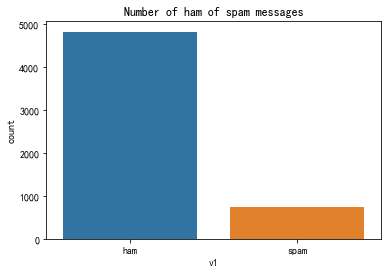

In [3]:
# 以图方式表示
sns.countplot(sms_data["v1"])
plt.xlabel("v1")
plt.title("Number of ham of spam messages")
plt.show()

注：ham是正常短信，spam是垃圾短信，其中属于ham的有

In [4]:
sms_data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
sms = sms_data.rename(columns = {'v1':'label','v2':'message'})

In [5]:
#去掉所有重复行
sms = sms.drop_duplicates()
sms.to_csv("E:/finalpaper/smm_drop.csv",encoding = 'latin-1',index = False)

添加长度特征，绘制直方图，按照label进行分类，bins是直方宽度

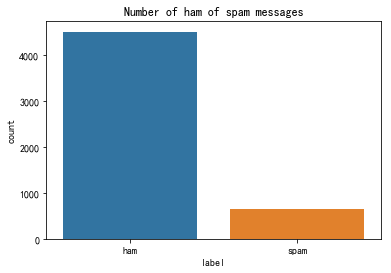

In [6]:
# 以图方式表示
sns.countplot(sms["label"])
plt.xlabel("label")
plt.title("Number of ham of spam messages")
plt.show()

In [7]:
sms.shape

(5169, 2)

In [8]:
#添加长度特征
sms['length'] = sms['message'].apply(len)
sms.hist(column = 'length',by = 'label',bins = 50,figsize = (11,5))
text_feat = sms['message'].copy()

In [9]:
def stemmer(text):
    text = text.split()
    words = ""
    for i in text:
        stemmer = SnowballStemmer("english")
        words += (stemmer.stem(i))+" "
    return words
text_feat = text_feat.apply(stemmer)

使用TfidfVectorizer用tf-idf方法进行词频统计

tf = 一个词在某个文件中的出现次数 /  该文件中所有词出现的次数总和

idf = log 文档总数 / （包含这个词的所有文档数之和 + 1）

idf表示一个词能将当前文件和其他文件区分开的能力，越大越好。

tf表示某个词出现在这段文本的频率，越大越好。

通过这个方法计算计算出来每个词语在每句话中的权重值，通过这个就可以进行学习。

In [10]:
vectorizer = TfidfVectorizer("english")
features = vectorizer.fit_transform(text_feat)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc

In [25]:
svc = SVC(kernel = 'linear')
knc = KNeighborsClassifier(n_neighbors = 23)
mnb = MultinomialNB(alpha = 0.018)
dtc = DecisionTreeClassifier(min_samples_split = 7,splitter = "random",class_weight = "balanced")
clfs = {'SVM':svc,'KNN':knc,'Naive Bayesian':mnb,'DecisionTree':dtc}

train_test_split进行样本划分，取出30%的样本作为测试集

score计算样本的准确度

cmat为取出的混淆矩阵，对角线上的值为正确预测对象，[0,0]为正常短信判定为正常短信，[1,1]为垃圾短信判定为垃圾短信，[0,1]为垃圾短信预测为了正常短信，[1,0]为正常短信预测成了垃圾短信

一个实例是正类并且被预测成正类，即为真正类（True positive）,如果实例是负类被预测成正类，称之为假正类（False positive）

threshold(阈值)

计算上述值之前应当先将ham与spamd的值数字化,ham正常短信1，spam垃圾短信0

SVM


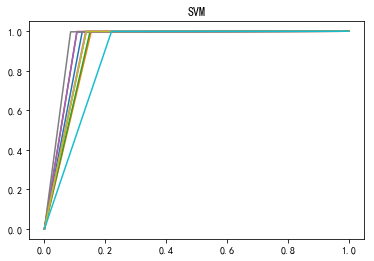

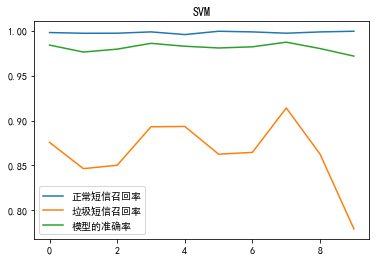

KNN


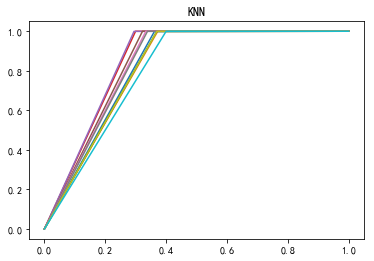

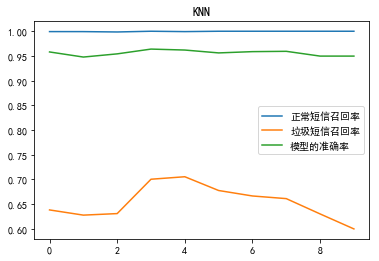

Naive Bayesian


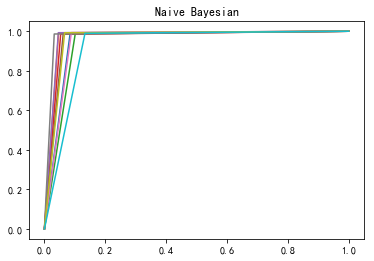

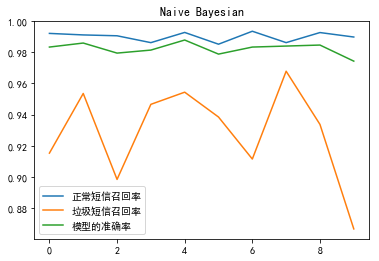

DecisionTree


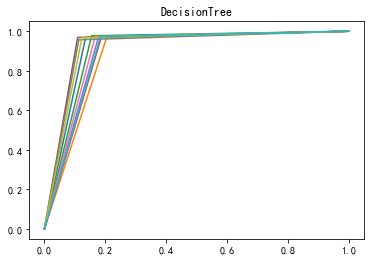

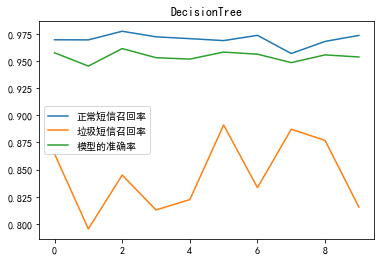

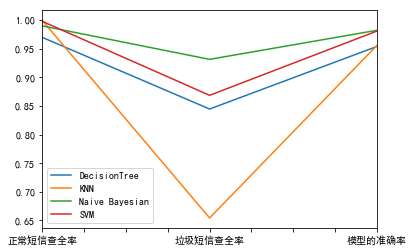

In [26]:
a = []
count_list_store = []
figure_count = 0
for key in clfs.keys():
    model = clfs[key]
    score = []
    hrecall = []
    precall = []
    b = []
    
    plt.figure(figure_count)
    print(key)
    
    for i in range(10):
        features_train,features_test,labels_train,labels_test = train_test_split(features,sms['label'],test_size = 0.3,random_state = 111 + i)
        model.fit(features_train,labels_train)
        score.append(sum(model.predict(features_test) == labels_test)*1.0/len(labels_test))
        cmat = confusion_matrix(model.predict(features_test),labels_test)
        fpr,tpr,thresholds = roc_curve(pd.DataFrame(labels_test).replace(('ham','spam'),(1,0)),pd.DataFrame(model.predict(features_test)).replace(('ham','spam'),(1,0)),pos_label = 1)
        hrecall.append(cmat[0,0]*1.0/(cmat[0,0] + cmat[1,0]))
        precall.append(cmat[1,1]*1.0/(cmat[0,1] + cmat[1,1]))
        recall = pd.DataFrame([hrecall,precall,score],index = [u'正常短信召回率',u'垃圾短信召回率',u'模型的准确率']).T
        
        plt.plot(fpr,tpr)
        
    b.append(np.mean(recall.iloc[:,0]))
    b.append((np.sum(recall.iloc[:,1]) - np.min(recall.iloc[:,1]) - np.max(recall.iloc[:,1]))/8)
    b.append(np.mean(recall.iloc[:,2]))
    a.append((key,b)) 
    
    plt.title(key)
    plt.show()
    figure_count = figure_count + 1
    
    plt.figure(figure_count)
    plt.plot(recall.iloc[:,0])
    plt.plot(recall.iloc[:,1])
    plt.plot(recall.iloc[:,2])
    plt.title(key)
    plt.legend()
    plt.show()
    
    figure_count = figure_count + 1
    
    count_list = pd.DataFrame()
    count_list['正常短信查全率'] = recall.iloc[:,0]
    count_list['垃圾短信查全率'] = recall.iloc[:,1]
    count_list['模型准确率'] = recall.iloc[:,2]
    count_list_store.append(count_list)
    
data = pd.DataFrame(dict(a),index = [u'正常短信查全率',u'垃圾短信查全率',u'模型的准确率'])
data.plot()
plt.show()

我们需要进行分析的有

决策树

K近邻

朴素贝叶斯

支持向量机

共4种分类方法

In [24]:
count_list_store[3]

,正常短信查全率,垃圾短信查全率,模型准确率
0,0.971616,0.881356,0.961315
1,0.956587,0.837209,0.940039
2,0.964809,0.855615,0.951644
3,0.974340,0.850267,0.959381
4,0.965288,0.883249,0.954868
5,0.964925,0.876777,0.952934
6,0.959529,0.817708,0.941973
7,0.960440,0.870968,0.949710
8,0.958955,0.881517,0.948420
9,0.969027,0.794872,0.947131


In [33]:
count_list_store[3].mean(axis = 0)

正常短信查全率    0.969892
垃圾短信查全率    0.844343
模型准确率      0.954030
dtype: float64